# Equation tearing

# Déclaration des variables #

In [6]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from mpl_toolkits.mplot3d import Axes3D

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True

import sympy as sp 

import itertools

On définit ici les variables utiles : 

$N$ le nombre de points de la simulation, $r_{min}$ le premier point considéré à l'intérieur
,$r_{max}$ le dernier point considéré à l'extérieur
,$n$ le nombre d'onde poloïdal, $m$ le nombre d'onde toroïdal, $B_0$, $R_0$, $q_s = \frac{m}{n}$ le facteur de sécurité sur la surface de résonance.


In [7]:
N = 1000
rmin = 1/N
rmax = 1-1/N
step = rmax/N
r0 = 0.5
psi0 = 1.
B0 = 1.
R0 = 1.
mu0 = 4*np.pi*10E-7
j0prime = -1
q0 = (-2*B0)/(mu0*j0prime*r0*R0)
n = 1.
m = 2.
qs = m/n
#vecteur des positions
v_r = np.linspace(rmin, rmax, N)

###Profils de courant et de facteur de sécurité

## Profil type step function ##

On modélise les profils de type fonction porte 


Pour modéliser la fonction en saut de courant, on utilise respectivement une fonction tangente hyperbolique et une fonction lorentzienne pour $j_{eq}(r)$ et $\frac{d j_{eq}}{dr}$.


In [23]:
def lor(x, gamma, x0): 
    return gamma/(2*np.pi*(gamma**2/4+(x-x0)**2))

En résolvant l'équation de Maxwell-Ampère, on trouve : 
\begin{equation}
\frac{1}{r} \frac{d}{dr}\left \frac{r^2}{q(r)} \right) = \frac{\mu_0 R_0 j_{eq}}{B_0}
\end{equation}
D'où l'expression analytique de $q(r)$ obtenue en intégrant : 

\begin{equation}
q(r) = q_0
q(r) = q_0 \left(\frac{r}{r_0} \right)^2

\end{equation}

In [16]:
def q(r, r0, j0p): 
    q0 = (-2*B0)/(r0*R0*mu0*j0p)
    if r < r0 : 
        return q0
    elif r > r0 : 
        return q0*r**2/r0**2

In [17]:
def profil_step(r0,j0p) : 
   v_jeq = np.tanh(N*(-v_r+r0))*(-r0*j0p)+ np.tanh(N*(r0))*(-r0*j0p)
   v_djeq = lor(v_r,1/N,r0)/np.max(lor(v_r,1/N,r0))*j0p*r0
   v_q = list(map(q, v_r, [r0 for i in range (N)], [j0p for i in range (N)]))
   return np.array([v_q,v_jeq, v_djeq])

In [18]:
def rres(profil): 
    "Renvoie la position radiale de la surface de résonnance"
    v_q = profil[0]
    return np.interp(qs,v_q,v_r)

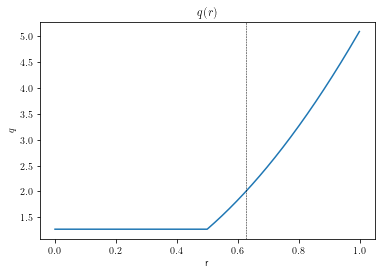

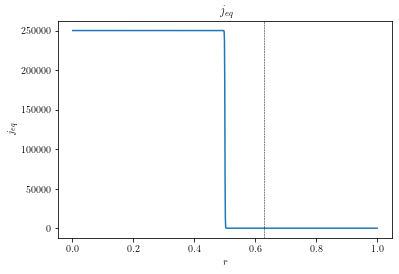

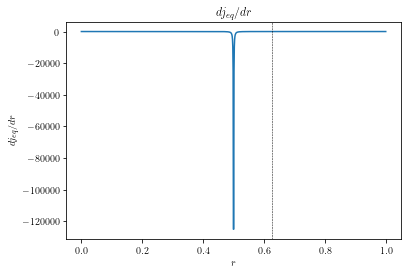

In [31]:
r0 = 0.5
j0p = -250000
profil = profil_step(r0,j0p)
    
def plot_pr(profil):
    v_q = profil[0]
    v_jeq = profil[1]
    v_djeq = profil[2]
    
    rs = rres(profil)
    
    plt.figure()
    plt.plot(v_r,v_q)
    #plt.plot(v_r,v_s)
    plt.axvline(x=rs, color = 'black',linestyle = '--',linewidth=0.5)
    plt.xlabel('r')
    plt.ylabel('$q$')
    plt.title('$q(r)$')
    plt.show()
    
    plt.figure()
    plt.plot(v_r,v_jeq)
    plt.axvline(x=rs, color = 'black',linestyle = '--',linewidth=0.5)
    plt.xlabel('$r$')
    plt.ylabel('$j_{eq}$')
    plt.title('$j_{eq}$')
    plt.show()
    
    plt.figure()
    plt.plot(v_r,v_djeq)
    plt.axvline(x=rs, color = 'black',linestyle = '--',linewidth=0.5)
    plt.xlabel('$r$')
    plt.ylabel('$ d j_{eq}/dr$')
    plt.title('$ d j_{eq}/dr$')
    plt.show()
    
plot_pr(profil)

### Profil de Wesson

De même pour les profils type Wesson : 
    $q(r) = q_a \cdot\frac{r^2}{1-(1-r^2)^(\nu+1)}$

In [ ]:
def wess(r, qa, nu):
    return qa*r**2/(1-(1 - r**2)**{(nu+1)})

On calcule ensuite les vecteurs correspondant à $q(r)$, $j_{eq}(r)$,$\frac{dj_{eq}}{dr}$ en utilisant la fonction gradient de Python.

In [27]:
def profil_wesson(qa,nu) : 
    '''Renvoie les vecteurs q, jeq et djeq selon le profil type Wesson'''
    v_q = wess(v_r,qa,nu)
    v_jeq = (np.gradient(v_r**2/v_q)*B0)/(mu0*R0*v_r*step)
    v_djeq = np.gradient(v_jeq)/step
    
    #Correction pour les premiers termes des dérivées 
    v_jeq[0] = np.interp(v_r[0],v_r[1:],v_jeq[1:])   
    v_djeq[1] = np.interp(v_r[1],v_r[2:],v_djeq[2:])
    v_djeq[0] = np.interp(v_r[0],v_r[2:],v_djeq[2:])
    return np.array([v_q,v_jeq, v_djeq])

In [33]:
qa = 3.5
nu = 1.8

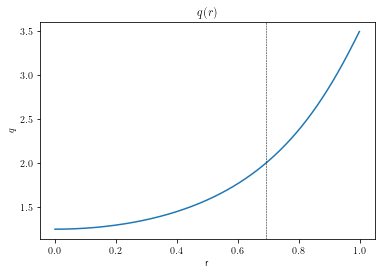

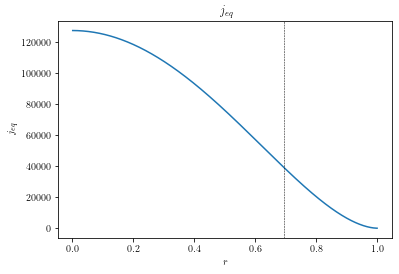

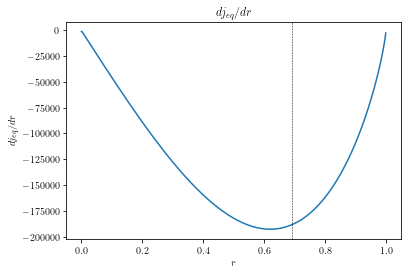

In [34]:
profil = profil_wesson(qa,nu)
plot_pr(profil)

# Résolution de l'équation tearing

Pour résoudre l'équation tearing, on part de chaque extrémité du rayon.

On utilise un schéma de Runge-Kutta d'ordre 2.

In [35]:
def ode2_stepRK(h,b,c,v_i):
     " solves y''+by' +c = 0 for one iteration with step h, Runge Kutta method. v_i must be of the form [y',y]"
     A = np.array([[-b,-c],[1,0]])
     return v_i + h*A.dot(v_i)+ h**2/2*(A.dot(A).dot(v_i))        

In [36]:
v_q = profil[0]
v_jeq = profil[1]
v_djeq = profil[2]
rs = rres(profil)

In [ ]:
def solve_tear_part(profil) : 
    "Résolution de l'équation kink-tearing et tracé des courbes, utilisation de Runge-Kutta d'ordre 2"
    v_sol = np.zeros((2,N))
    v_sol[:,0] = [1,0] #ici 1 est le psi prime initial (arbitraire et on ajuste)
        
    #Maillage équidistant à droite et à gaude de rs
    b = np.arange(rs+step/2,rmax,step)
    a = -np.arange(-(rs-step/2),-rmin,step)
    a = np.sort(a)
    v_r = np.concatenate((a,b))
        
    #Forward
    i_f = 0
    while v_r[i_f+1] < rs : #lorsqu'on s'intéresse à i_f on calcule le terme suivant
        djeq = v_djeq[i_f]
        r = v_r[i_f]
        q = v_q[i_f]
        c = - m**2/r**2 + mu0*q*qs*R0*djeq/((q-qs)*r*B0)
        b = 1/r
        v_i = v_sol[:,i_f]      
        v_sol[:,i_f+1] = ode2_stepRK(step,b,c,v_i)
        i_f = i_f +1

     #Backward
    i_b = len(v_r)-1 #On devrait partir de N-2 car la condition aux limites est sur v_r[N-1]
    v_sol[:,i_b] = [1,0] #CL à l'extrémité droite
    while v_r[i_b] > rs :
        djeq = v_djeq[i_b]
        r = v_r[i_b]
        q = v_q[i_b]
        c = - m**2/r**2 + mu0*q*qs*R0*djeq/((q-qs)*r*B0)
        b = 1./r    
        v_i = v_sol[:,i_b]      
        v_sol[:,i_b-1] = ode2_stepRK(step,b,c,v_i)
        i_b = i_b - 1
        v_sol[0,i_b:] = - v_sol[0,i_b:] #vraies dérivées par rapport au sens de parcours r croissant
        
        
        #Psi, Dpsi
        psi = v_sol[1,:]
        dpsi = v_sol[0,:]
        #Figures
        plt.figure()
        plt.plot(v_r[:i_f], psi[:i_f])
        plt.show()
        
        plt.figure()
        plt.plot(v_r[i_f:], psi[i_f:])
        plt.show()

In [ ]:
solve_tear_part(profil)

In [37]:
def solve_tear(profil) :
    "Résolution de l'équation kink-tearing et tracé des courbes, utilisation de Runge-Kutta d'ordre 2"
    v_sol = np.zeros((2,N))
    v_sol[:,0] = [1,0] #ici 1 est le psi prime initial (arbitraire et on ajuste)
        
    #Maillage équidistant à droite et à gaude de rs
    b = np.arange(rs+step/2,rmax,step)
    a = -np.arange(-(rs-step/2),-rmin,step)
    a = np.sort(a)
    v_r = np.concatenate((a,b))
        
    #Forward
    i_f = 0
    while v_r[i_f+1] < rs : #lorsqu'on s'intéresse à i_f on calcule le terme suivant
        djeq = v_djeq[i_f]
        r = v_r[i_f]
        q = v_q[i_f]
        c = - m**2/r**2 + mu0*q*qs*R0*djeq/((q-qs)*r*B0)
        b = 1/r
        v_i = v_sol[:,i_f]      
        v_sol[:,i_f+1] = ode2_stepRK(step,b,c,v_i)
        i_f = i_f +1

     #Backward
    i_b = len(v_r)-1 #On devrait partir de N-2 car la condition aux limites est sur v_r[N-1]
    v_sol[:,i_b] = [1,0] #CL à l'extrémité droite
    while v_r[i_b] > rs :
        djeq = v_djeq[i_b]
        r = v_r[i_b]
        q = v_q[i_b]
        c = - m**2/r**2 + mu0*q*qs*R0*djeq/((q-qs)*r*B0)
        b = 1./r    
        v_i = v_sol[:,i_b]      
        v_sol[:,i_b-1] = ode2_stepRK(step,b,c,v_i)
        i_b = i_b - 1
    v_sol[0,i_b:] = - v_sol[0,i_b:] #vraies dérivées par rapport au sens de parcours r croissant
    
    #Raccordement 
    v_sol[:,:i_f] = v_sol[:,:i_f]/v_sol[1,i_f-1]
    v_sol[:,i_f:] = v_sol[:,i_f:]/v_sol[1,i_f]
    
    #Calculs et tracés des tangentes
    v_r = np.concatenate(([0],v_r)) #On rajoute le point de départ à 0
    t_g = v_sol[0,i_f-1]*(v_r - v_r[i_f-1]) + v_sol[1,i_f-1] #gauche
    t_d = v_sol[0,i_f]*(v_r - v_r[i_f]) + v_sol[1,i_f] #droite
    
    #Delta prime
    deltap = v_sol[0,i_f] - v_sol[0,i_f+1]
      
    #Plots
    plt.figure() #Dpsi
    plt.axvline(x=rs, color = 'black',linestyle = ':')
    plt.plot(v_r,v_sol[0,:len(v_r)])
    plt.title(str(deltap) )
    
    plt.figure() #Psi
    plt.axvline(x=rs, color = 'black',linestyle = ':')
    plt.plot(v_r[i_f-30:i_f+1],t_g[i_f-30:i_f+1],'g--')
    plt.plot(v_r[i_b:i_b+30],t_d[i_b:i_b+30],'g--')
    plt.plot(v_r, v_sol[1,:len(v_r)])
    plt.title(str(deltap) )
    
    return (v_sol, i_f, deltap, v_r) #i_f = indice du premier point de la solution backward

(array([[ 3.66576031e-02,  4.48998841e-02,  5.44227272e-02, ...,
         -3.65930533e+00, -3.66295942e+00, -0.00000000e+00],
        [ 0.00000000e+00,  2.63583263e-05,  6.99583788e-05, ...,
          3.65746642e-03,  0.00000000e+00,  0.00000000e+00]]),
 625,
 0.04578203061872088,
 array([0.        , 0.00178241, 0.00278141, 0.00378041, 0.00477941,
        0.00577841, 0.00677741, 0.00777641, 0.00877541, 0.00977441,
        0.01077341, 0.01177241, 0.01277141, 0.01377041, 0.01476941,
        0.01576841, 0.01676741, 0.01776641, 0.01876541, 0.01976441,
        0.02076341, 0.02176241, 0.02276141, 0.02376041, 0.02475941,
        0.02575841, 0.02675741, 0.02775641, 0.02875541, 0.02975441,
        0.03075341, 0.03175241, 0.03275141, 0.03375041, 0.03474941,
        0.03574841, 0.03674741, 0.03774641, 0.03874541, 0.03974441,
        0.04074341, 0.04174241, 0.04274141, 0.04374041, 0.04473941,
        0.04573841, 0.04673741, 0.04773641, 0.04873541, 0.04973441,
        0.05073341, 0.05173241, 0.0527

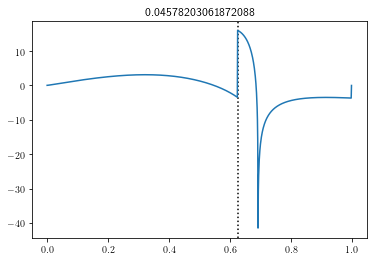

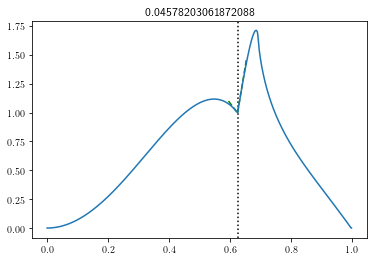

In [40]:
solve_tear(profil)

In [41]:
def f(x):
    k =-( m**2/v_r - mu0*qs*v_q*R0*v_djeq/B0*(v_q - qs))
    return psis*(k*np.log(abs(x))+k+k**2*x*np.log(abs(x))+1/2*k**2*x- 3*k**2*x/2)

def g(x):
    k = -( m**2/v_r - mu0*qs*v_q*R0*v_djeq/B0*(v_q - qs))
    return 1+k*x+3*k**2*x**3/12

In [42]:
x = v_r - rs

In [43]:
f(x)

NameError: name 'psis' is not defined